# Proyecto final de Audio

In [ ]:
from google.colab import userdata

fpath = '/content/audiopfinal/data'


token = userdata.get('ghToken')
!git clone https://{token}@github.com/Cosuki/audiopfinal.git > /dev/null 2>&1


In [4]:

import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.io.wavfile import read
from IPython.display import Audio
import scipy.io.wavfile as wav
from matplotlib.pyplot import specgram
from scipy.signal import spectrogram

fpath = './data'

def pltlegacy(ax, title, xLabel, yLabel):
  if type(ax) == np.ndarray or type(ax) == plt.Axes:
    ax.set_title(title)
    # ax.set_ylim(top=10000)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    if not yLabel: ax.get_yaxis().set_visible(False)
    # if not xLabel: ax.get_xaxis().set_visible(False)
  else:
    ax.title(title)
    # ax.set_ylim(top=10000)
    ax.xlabel(xLabel)
    ax.ylabel(yLabel)

def getpltmtplt(ax, key, data, sr, xLabel, yLabel):
    Pxx, freqs, bins, im = ax.specgram(data, NFFT=1024, srG=sr, noverlap=128, cmap='viridis')
    pltlegacy(ax, f'{key}', xLabel, yLabel)
    return Pxx, freqs, bins, im

def getSpecSig(ax, key, data, sr, xLabel, yLabel):
  f, t_spec, Sxx = spectrogram(data, sr)
  Sxx += 1e-10
  pltlegacy(ax, f'{key}', xLabel, yLabel)
  return ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')

In [5]:
srG, guitar = io.wavfile.read(f'{fpath}/Police-vocals-guitar.wav')
srV, voice = io.wavfile.read(f'{fpath}/Emily_Linge-vocals.wav')

print(f'{srG=}, {srV=}')

guitar = guitar[0: 60*srG]
voice = voice[0: 60*srV]

display(Audio(guitar, rate=srG), Audio(voice, rate=srV))

srG=22050, srV=22050


In [16]:
from scipy.linalg import toeplitz
from scipy.linalg import solve

def get_lpc(s, p=20):
    """ compute the LPC analysis using the autocorrelation method

    Parameters
    ----------
    x : numpy array
        windowed signal frame as a numpy 1D array.
    p : int
        model order.

    Returns
    -------
    ak : numpy array
         model coefficients.
    e : float
        minimum mean squared error.
    e_norm : float
             normalized minimum mean squared error.
    """
    # frame length
    N = s.shape[0]

    # compute autocorrelation values
    r = np.zeros((p+1, 1))
    for k in range(p+1):
        r[k] = np.dot(s[:(N-k)].T, s[k:])

    # solve to compute model coefficients
    ak = solve(toeplitz(r[:p]), r[1:p+1]).squeeze()

    # compute mean squared error
    e = r[0] - np.dot(ak.T, r[1:p+1])


    # compute normalized mean squared error
    e_norm = e / r[0] if r[0] != 0 else 0

    return ak, e, e_norm

  

In [40]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

for l in np.array_split(a, 7):
    print(l)

[1 2 3]
[4 5 6]
[7 8 9]
[10 11]
[12 13]
[14 15]
[16 17]


In [46]:
def lpc_analysis(sig, sr, t, getPlot=False, p=0, retType='dB', Ndft=1024):
    
    n = int(t*sr)
    window = signal.windows.get_window('hann', n) # smoothing window
    for chunk in np.array_split(sig, int(len(sig)/n)):
        if len(window) != len(chunk):
            window = signal.windows.get_window('hann', len(chunk)) # smoothing window
        s_win = chunk * window # windowed signal frame
        
        X = np.fft.fft(s_win, Ndft) # spectrum of the signal frame
        f = np.fft.fftfreq(Ndft) * srG # frequency values
        p = p if p else int(sr/1000) # model order
        ak, e, e_norm = get_lpc(s_win, p) # apply lpc analysis to signal frame
        
        # filter obtained from the lpc analysis
        S = 1
        U = np.concatenate([[1], -ak])
        G = np.sqrt(e) # compute gain

        # compute the frequency response of the digital filter
        w, H = signal.freqz(G*S, U, worN=Ndft, whole=True)
        fw = w / (2 * np.pi) * srG

        # impulse response of the LPC filter
        delta = np.zeros(n)
        delta[0] = 1
        h = signal.lfilter(G*S, U, delta)

        # magnitude spectrum
        magX = np.abs(X)
        ind_fmx = int(Ndft/2)
        # magnitude spectrum
        magH = np.abs(H)
        ind_fmx = int(Ndft/2)
        
        if getPlot:
            # plot the frequency response
            plt.figure(figsize=(12,6))
            ax1 = plt.subplot()
            ax1.set_title('Signal frame spectrum and frequency response of LPC filter')
            ax1.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k')
            ax1.plot(f[:ind_fmx], 20 * np.log10(magH[:ind_fmx]), 'r')
            ax1.set_ylabel('Magnitude (dB)')
            ax1.set_xlabel('Frequency (Hz)')
            plt.tight_layout()
            plt.show()
        
    if retType == 'dB':
        return 20 * np.log10(magX[:ind_fmx])
    else:
        return magX[:ind_fmx]

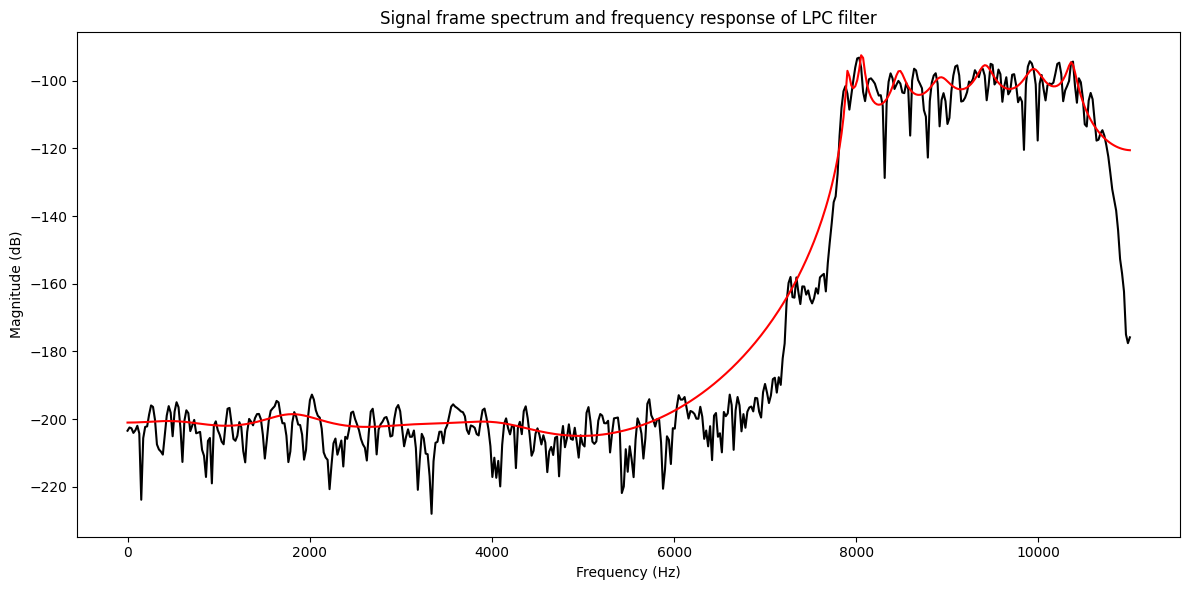

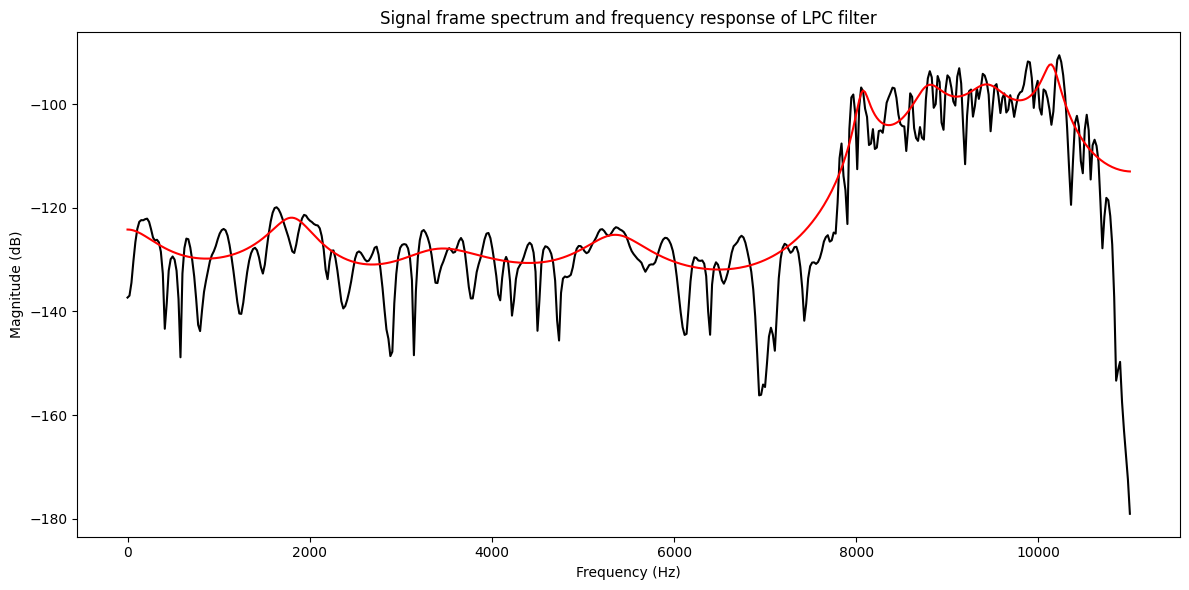

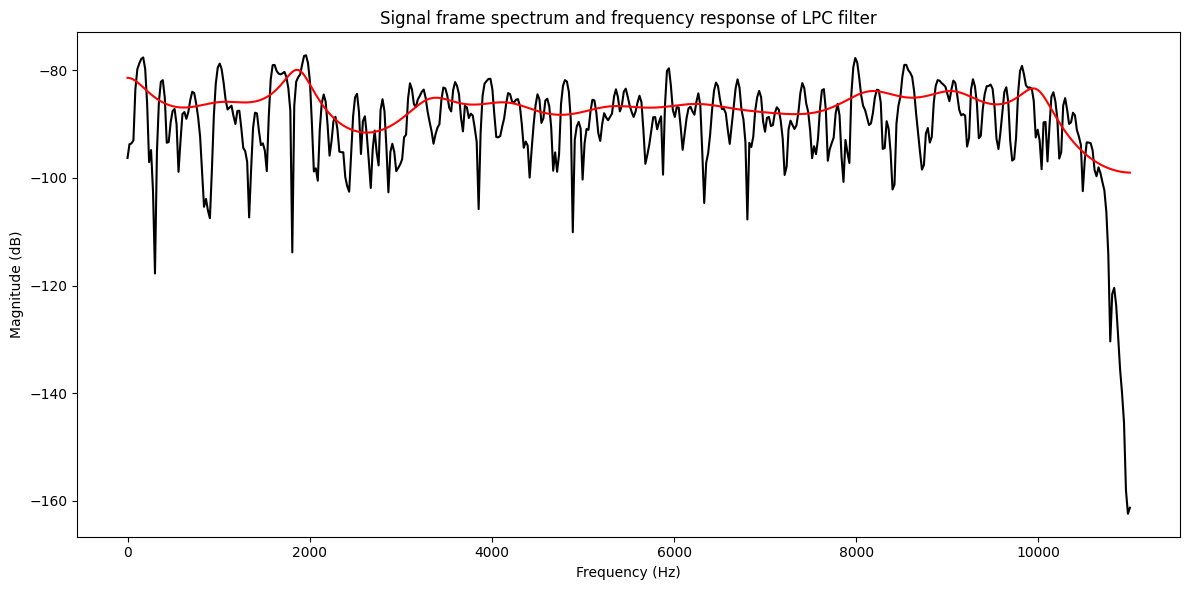

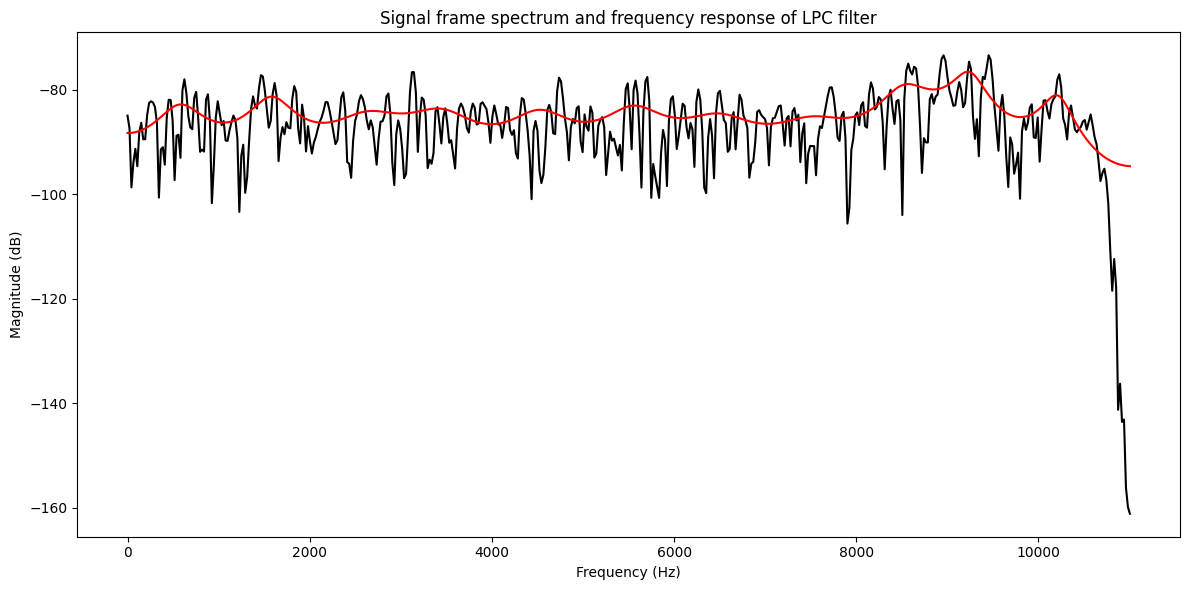

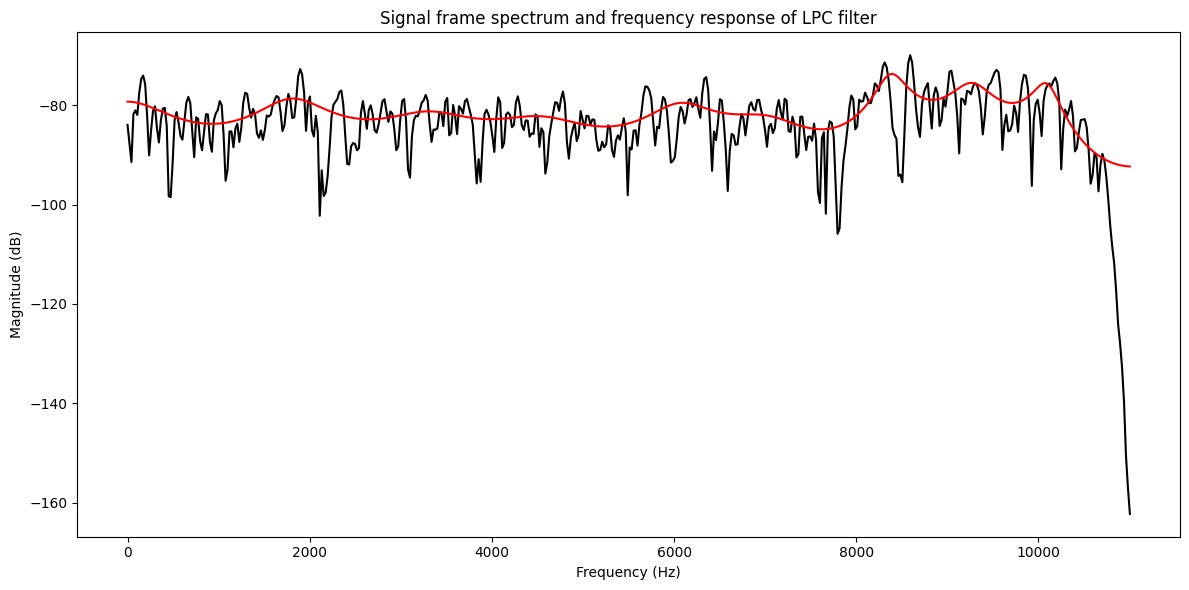

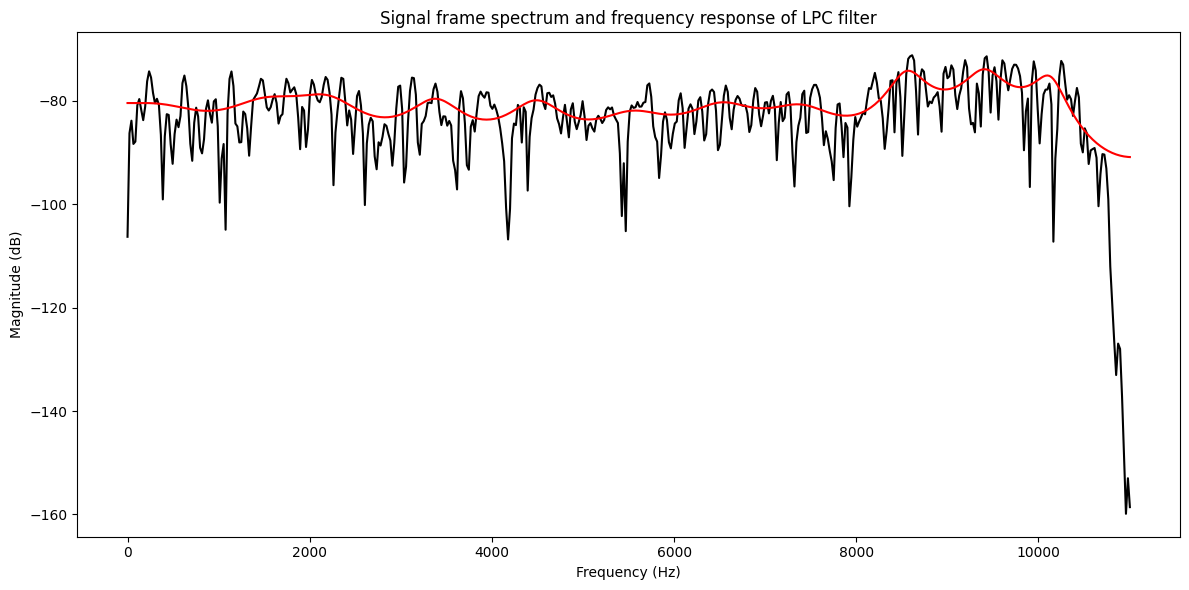

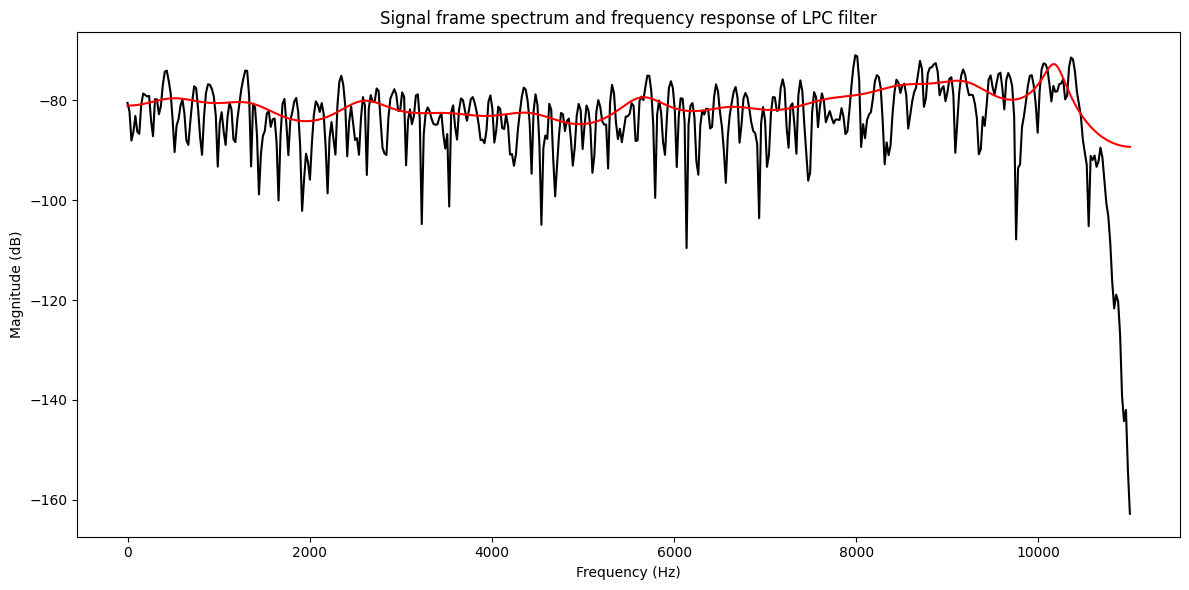

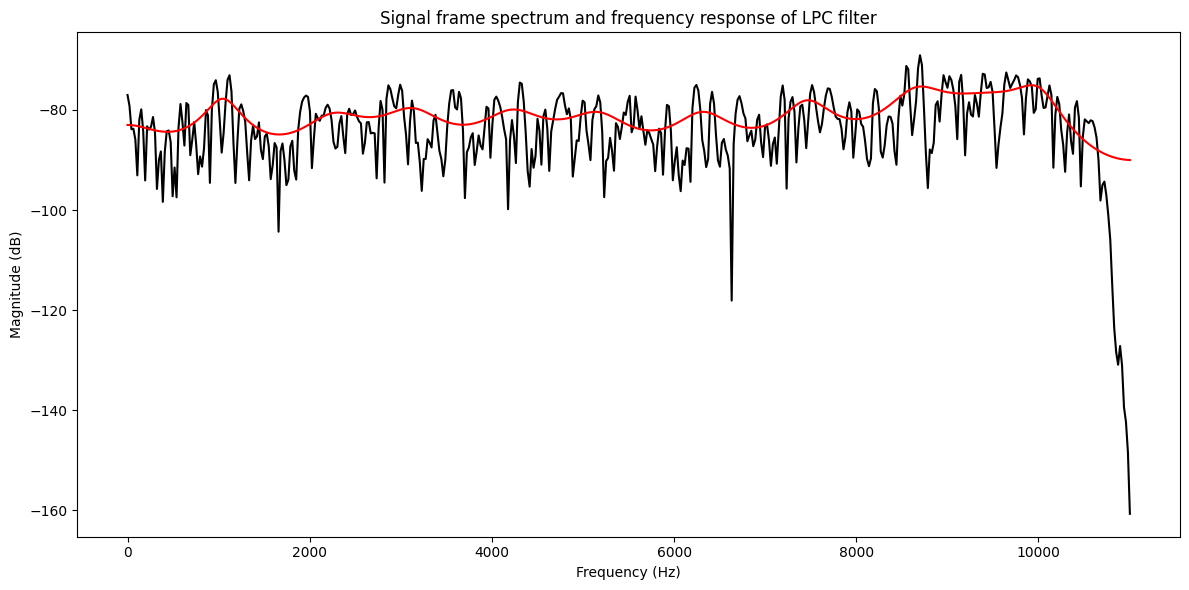

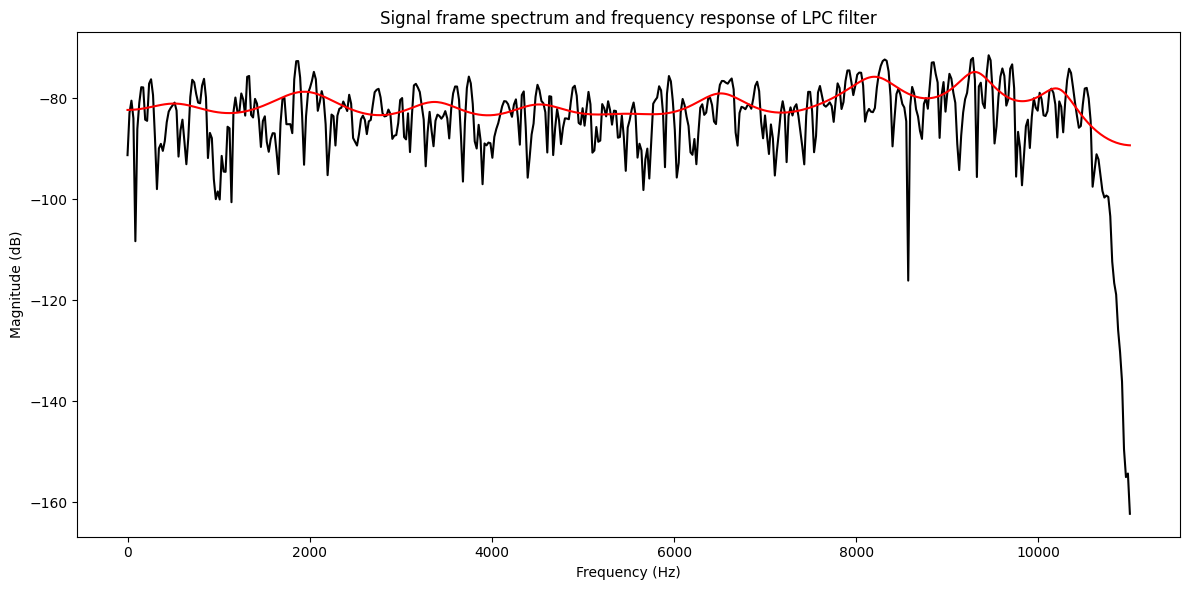

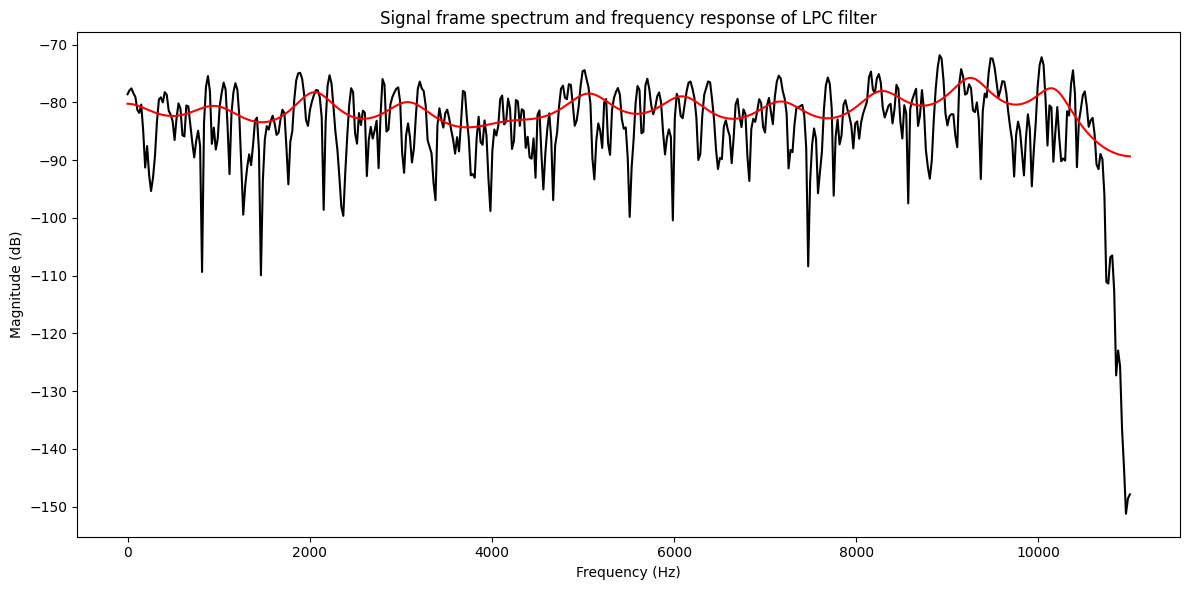

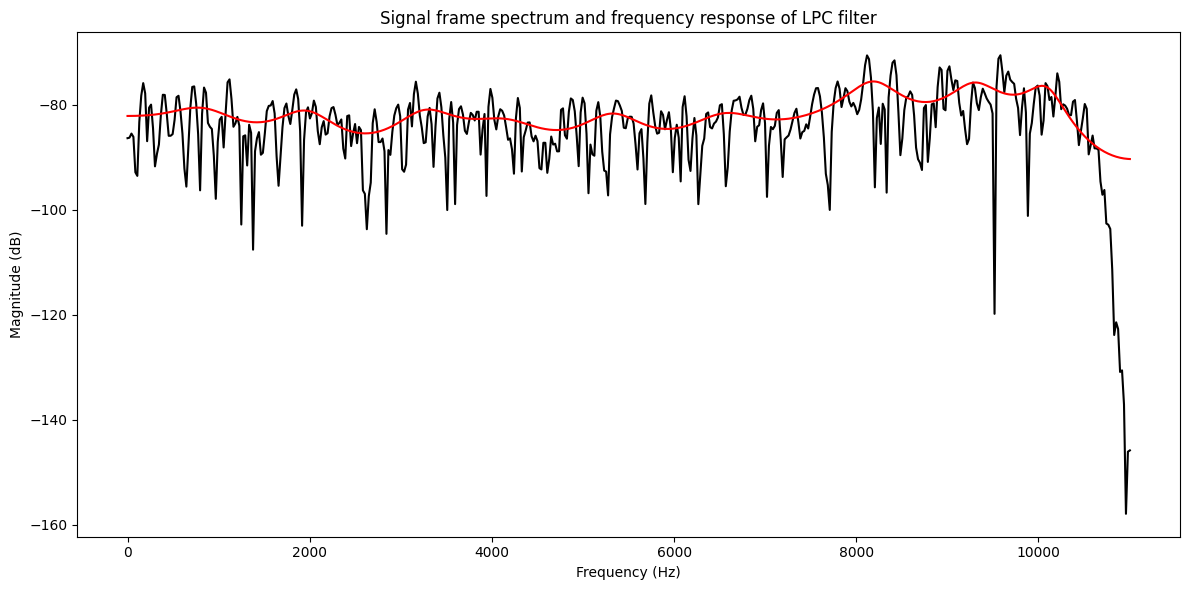

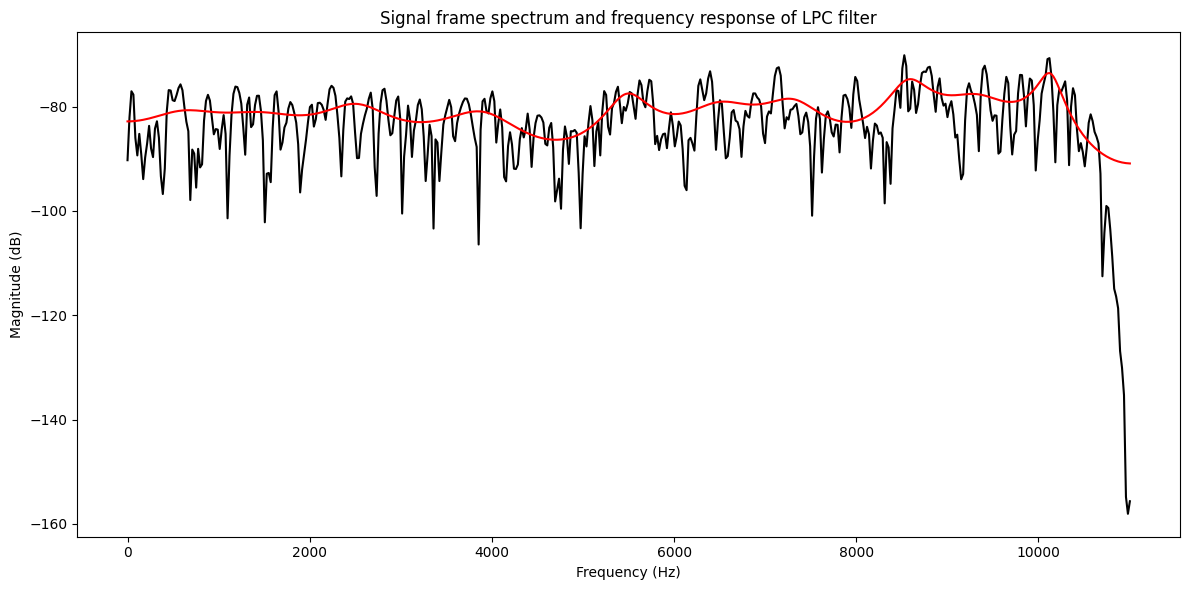

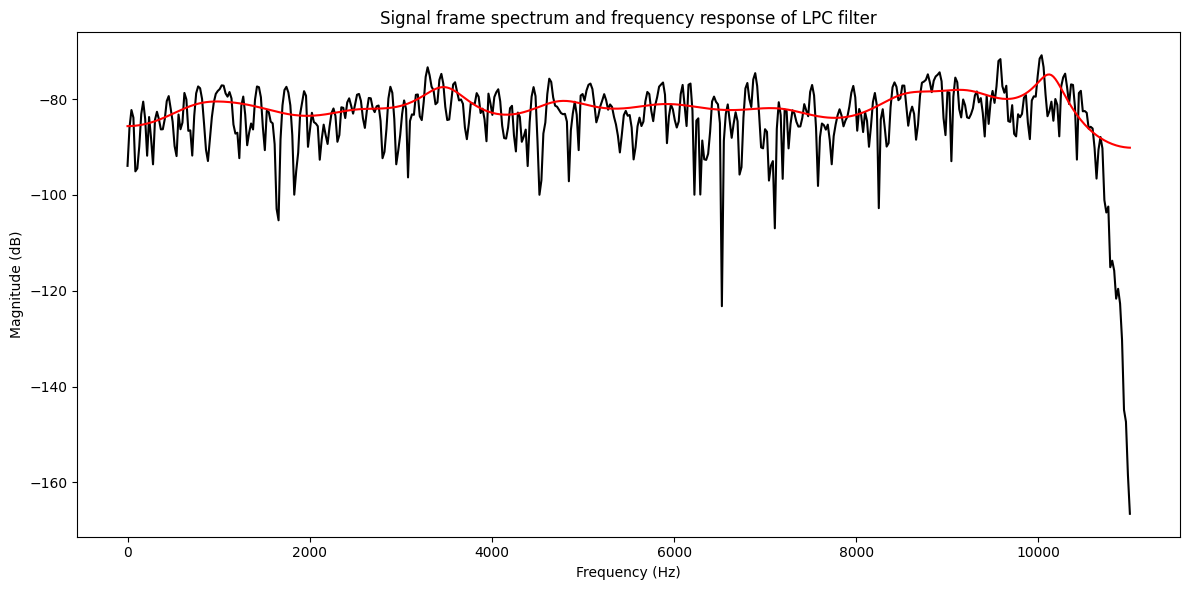

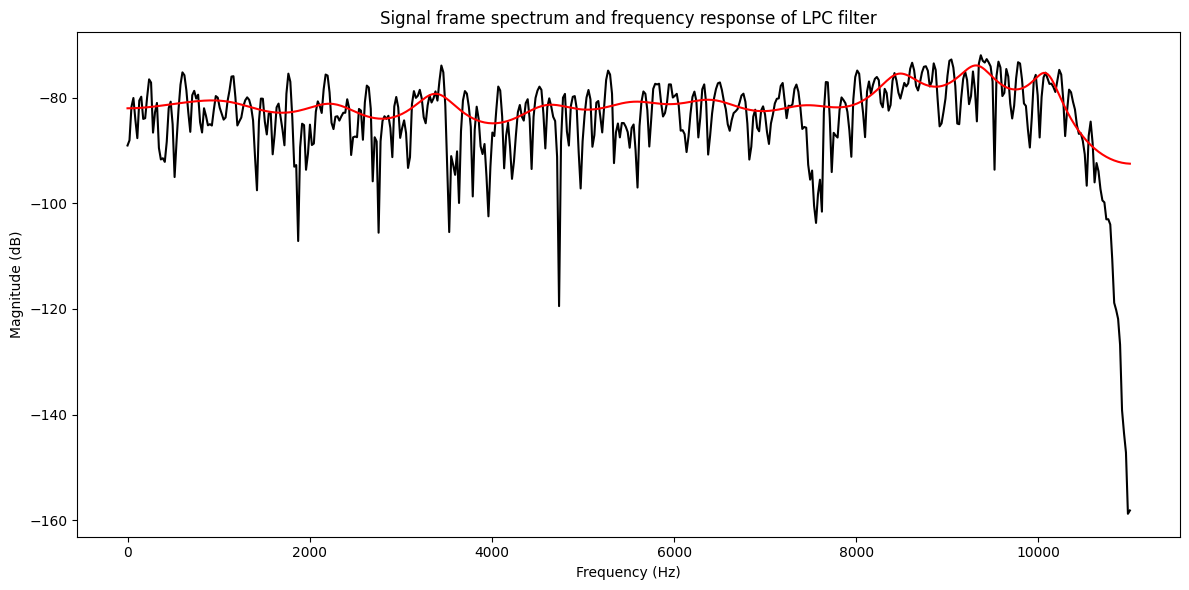

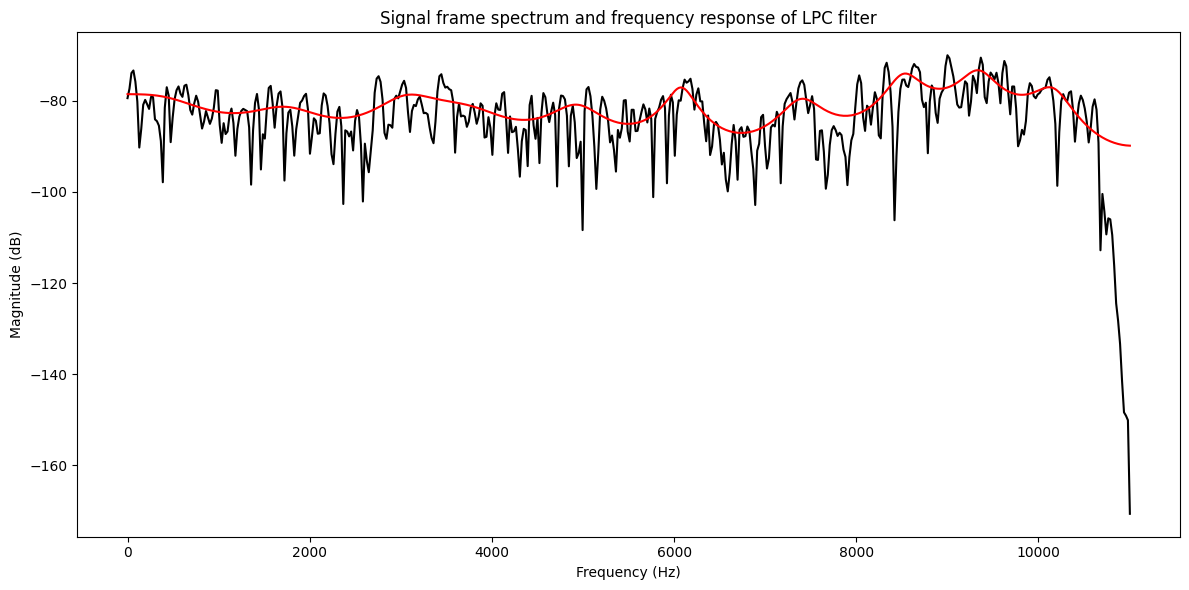

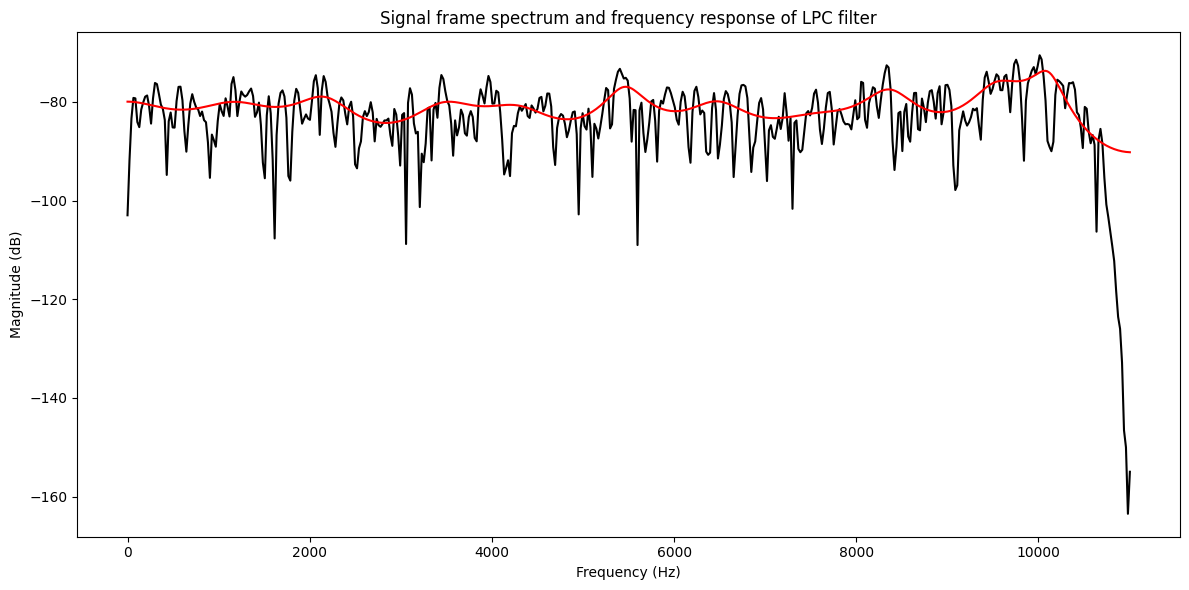

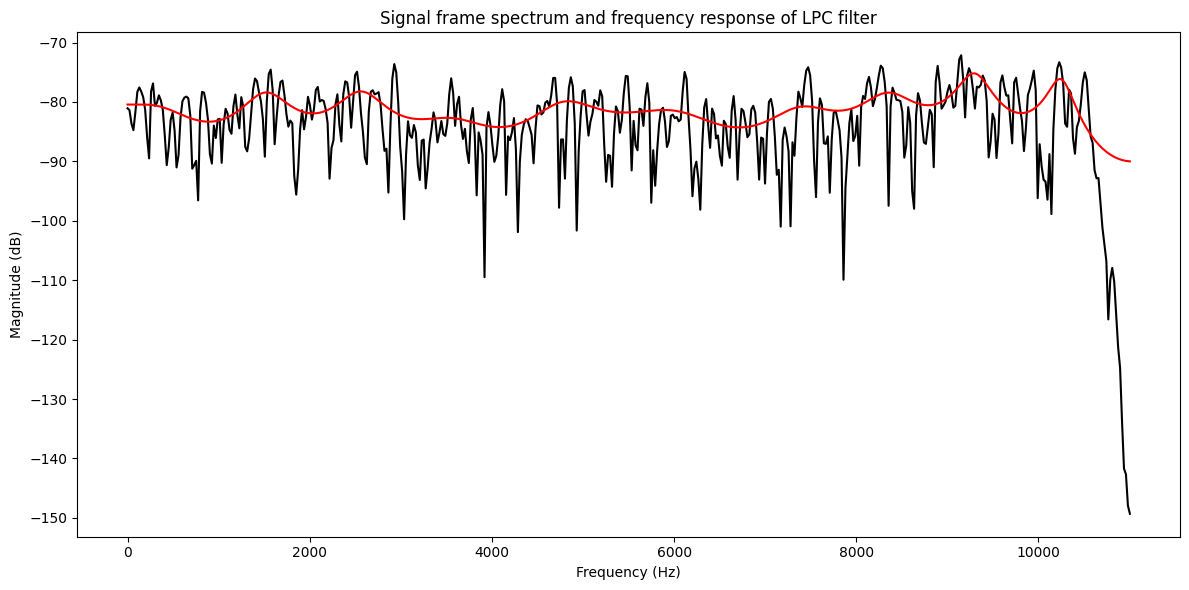

KeyboardInterrupt: 

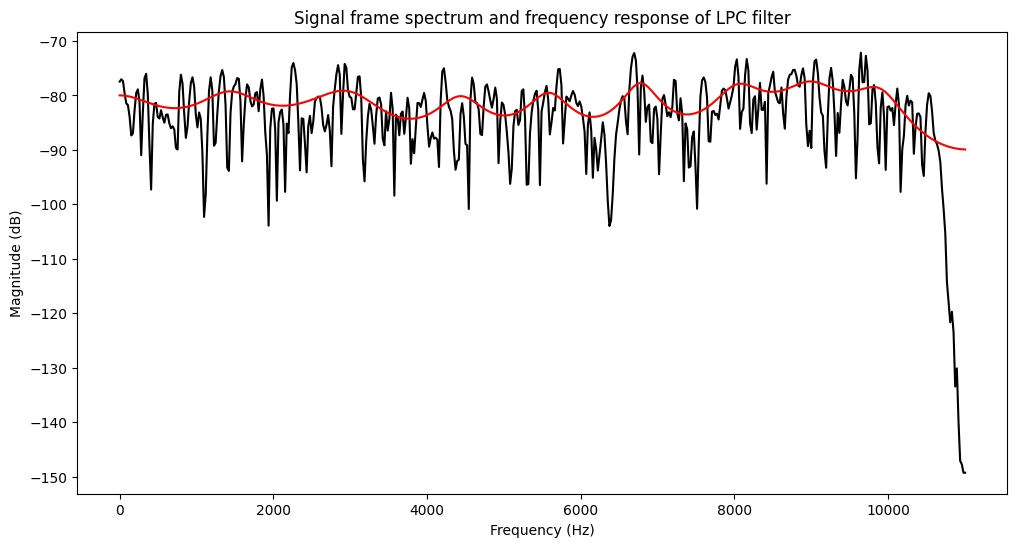

In [47]:
lpc_analysis(guitar, srG, .030, True)